# ***Библиотеки, функции, методы и константы***

In [ ]:
!pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount("/content/disk")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca as gca
from matplotlib.pyplot import grid as grid
from mpl_toolkits.basemap import Basemap
import math
import scipy
from scipy import integrate
from scipy.ndimage import rotate
from scipy.spatial.transform import Rotation as R
%matplotlib inline

Drive already mounted at /content/disk; to attempt to forcibly remount, call drive.mount("/content/disk", force_remount=True).


In [ ]:
G = 6.673 * 1e-11
M = 5.972 * 1e24
radius = 6371000
ISS_height = 500e3
ISS_time = 90*60
ISS_mass = 440075

In [ ]:
Oz = [0, 0, 1]

In [ ]:
def get_orbit_n(r, orbital_inclination, solution_one=False):
    phi = orbital_inclination * math.pi / 180
    z = math.cos(phi)

    p1 = -r[1] / r[0]
    p2 = -z * r[2] / r[0]
    
    a = p1 ** 2 + 1
    b = 2 * p1 * p2
    c = p2 ** 2 - math.sin(phi) ** 2
    y1 = ((-b + math.sqrt(b ** 2 - 4 * a * c)) / (2 * a))
    y2 = ((-b - math.sqrt(b ** 2 - 4 * a * c)) / (2 * a))

    x1 = p1 * y1 + p2
    x2 = p1 * y2 + p2

    n1 = np.array([x1, y1, z])
    n2 = np.array([x2, y2, z])

    if solution_one:
        return n1
    return n2

In [ ]:
def odefun(x, t):
    return np.array([x[3:6], -G*M*x[0:3] / ((np.linalg.norm(x[0:3]))**3)]).reshape(-1)

# ***Создаём модель Земли***

In [ ]:
def mpl_sphere(image_file, fig):
    img = plt.imread(image_file)

    theta = np.linspace(0, np.pi, img.shape[0])
    phi = np.linspace(0, 2*np.pi, img.shape[1])

    count = 180
    theta_inds = np.linspace(0, img.shape[0] - 1, count).round().astype(int)
    phi_inds = np.linspace(0, img.shape[1] - 1, count).round().astype(int)
    theta = theta[theta_inds]
    phi = phi[phi_inds]
    img = img[np.ix_(theta_inds, phi_inds)]

    theta,phi = np.meshgrid(theta, phi)

    x = np.sin(theta) * np.cos(phi) * radius * earth_scale
    y = np.sin(theta) * np.sin(phi) * radius * earth_scale
    z = np.cos(theta) * radius * earth_scale

    return x.T, y.T, z.T, img/255

# ***Инициализируем параметры***

В нашем случае для упрощения работы траектория спутника проходит над северным полюсом, следовательно, наклон орбиты спутника будет составлять 90 градусов

In [ ]:
cords = [-43.07, -61.5]
orbital_inclination = 90

North = cords[0] * math.pi / 180
East = cords[1] * math.pi / 180

# ***Вычисление***

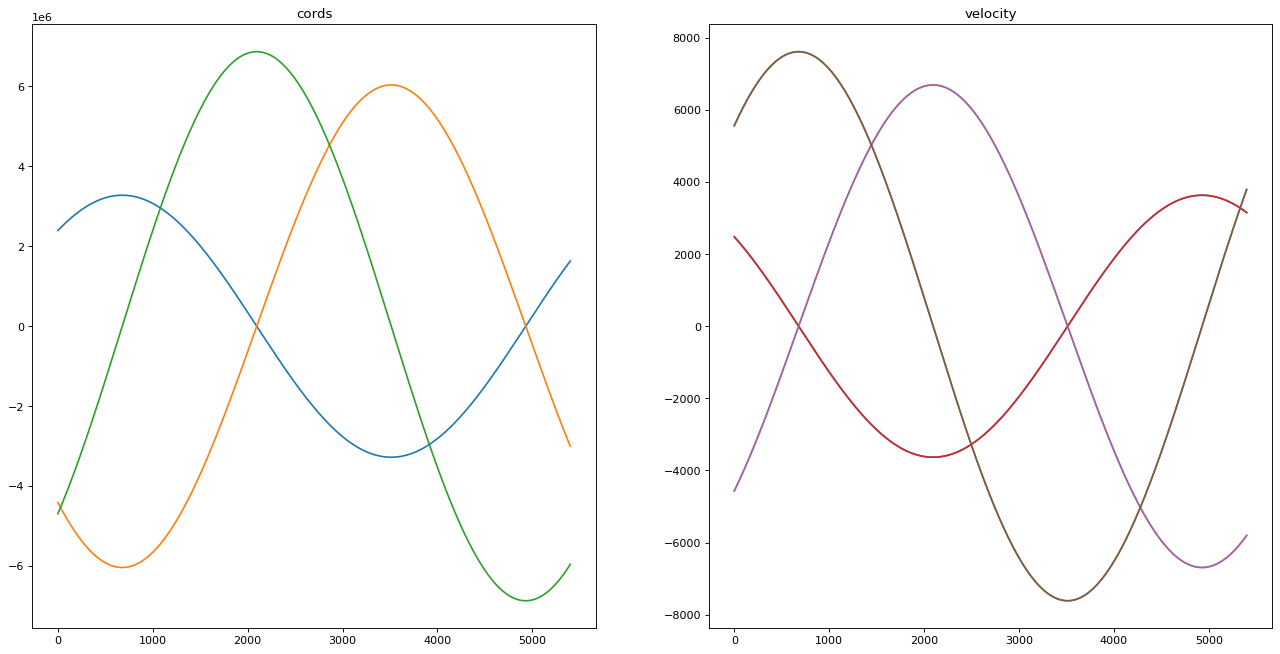

In [ ]:
satelite_velocity = math.sqrt(G * M / (radius + ISS_height))
init_pos = np.array([math.cos(North)*math.cos(East),
                     math.cos(North) * math.sin(East),
                     math.sin(North)])
orbit_norm = get_orbit_n(init_pos, orbital_inclination)
tau = np.cross(orbit_norm, init_pos)

r0 = init_pos*(radius + ISS_height)
v0 = tau * satelite_velocity
tspan = np.linspace(0, int(ISS_time), 10 ** 6)
x0 = np.concatenate((r0, v0), axis=None)

x = scipy.integrate.odeint(odefun, x0, tspan, rtol=1e-13, atol=1e-14)
trajectory = x[:, 0:3]
velocity = x[:, 3:6]
trajectory_corrected = np.zeros_like(trajectory)
for i in range(len(tspan)):
    current_time = tspan[i]
    angle_Earth_rotation = -2 * math.pi * current_time / (24 * 60 * 60)
    r = R.from_rotvec(angle_Earth_rotation * np.array([0, 0, 1]))
    current_point = trajectory[i, :]
    current_point_corrected = r.apply(current_point)
    trajectory_corrected[i, :] = current_point_corrected
fig = plt.figure(figsize=(20, 10), dpi=80)

ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
ax.plot(tspan, x[:, 0:3])
ax.set_title('cords')
ax1.plot(tspan, x[:, 3:6])
ax1.set_title('velocity')
plt.plot(tspan, x[:, 3:6])

TypeError: ignored

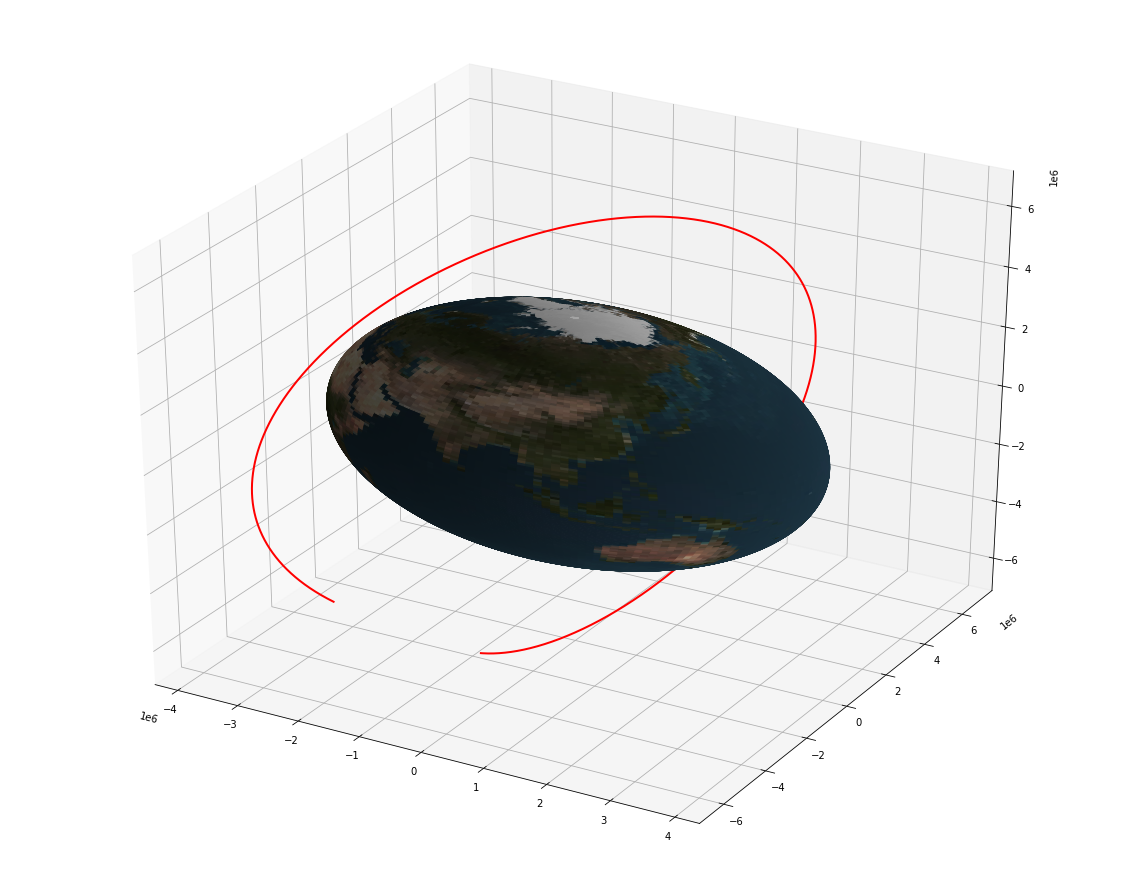

In [ ]:
earth_scale = 0.6
fig = plt.figure(figsize=(20, 16))

x, y, z, img = mpl_sphere('/content/disk/MyDrive/images/map.jpg', fig)

ax = fig.add_subplot(projection='3d')

ax.plot_surface(x, y, z, facecolors=img, cstride=1, rstride=1)
ax.plot(-trajectory_corrected[:, 0], trajectory_corrected[:, 1], trajectory_corrected[:, 2],
           'r', linewidth=2)
ax.plot(0, 0, ISS_height + radius, 'o')
ax.set_zlim(-8e6, 8e6)
ax.set_xlim(-8e6, 8e6)
ax.set_ylim(-8e6, 8e6)

# ***Проверка того, что спутник не входит в атмосферу Земли (для упрощения использована высота 270 километров)***

In [ ]:
dist_from_earth = np.sqrt(trajectory_corrected[:, 0] ** 2 + trajectory_corrected[:, 1] ** 2 + trajectory_corrected[:, 2] ** 2) - radius
np.where(dist_from_earth < 270e3, dist_from_earth, 0).nonzero()

(array([], dtype=int64),)

# ***Энергия спутника***

In [ ]:
kinetic_energy   = np.zeros(trajectory_corrected.shape[0])
potential_energy = np.zeros(trajectory_corrected.shape[0])

for i in range(tspan.shape[0]):
    current_point = trajectory[i, :]
    kinetic_energy[i] = 0.5 * ISS_mass * np.dot(velocity[i, :], velocity[i, :])
    potential_energy[i] = -G * M * ISS_mass / np.linalg.norm(current_point)
    
total_energy = kinetic_energy + potential_energy

(-30000000000000.0, 30000000000000.0)

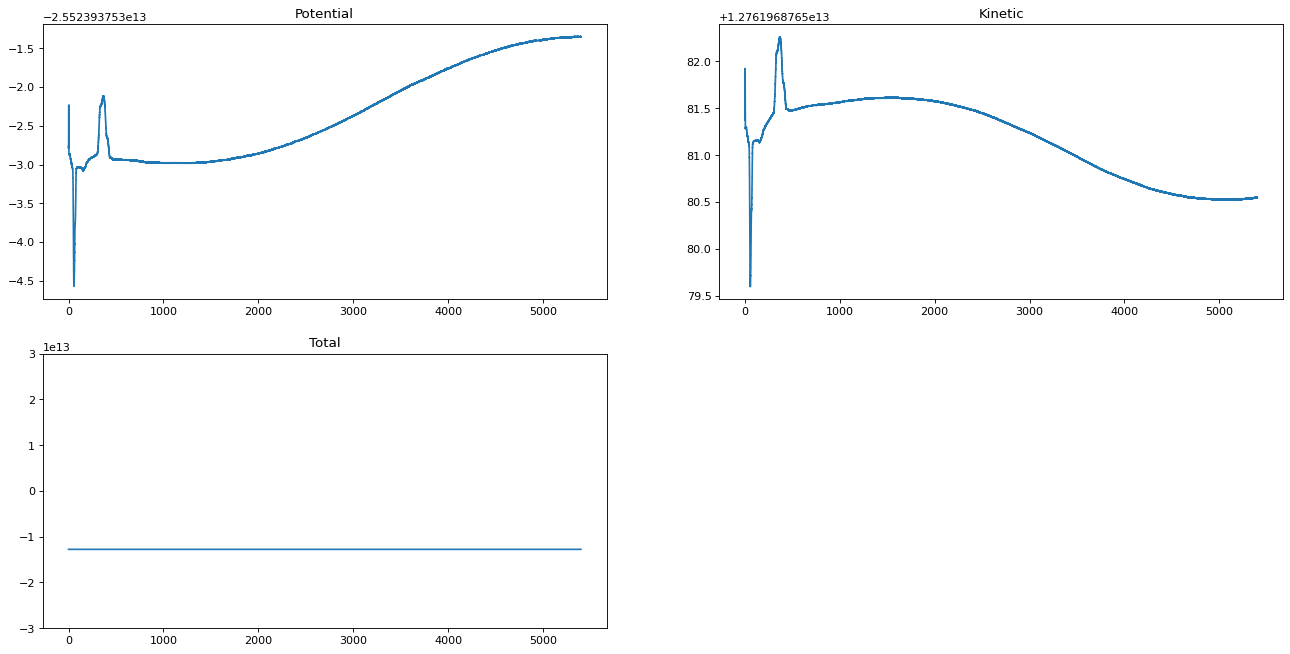

In [ ]:
fig = plt.figure(figsize=(20, 10), dpi=80)

ax = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
ax2 = fig.add_subplot(223)
ax.plot(tspan, potential_energy)
ax.set_title('Potential')
ax1.plot(tspan, kinetic_energy)
ax1.set_title('Kinetic')
ax2.plot(tspan, total_energy)
ax2.set_title('Total')
ax2.set_ylim(-3e13, 3e13)
#ax.set_ylim(-8e6, 8e6)
#plt.plot(tspan, x[:, 3:6])